# Upperair Obs with Contours

Using the declarative syntax to plot upperair observations and overlay contours.

### Import Packages

In [1]:
from datetime import datetime, timedelta

import cartopy.crs as ccrs
from metpy.io import add_station_lat_lon
from metpy.plots import declarative
from metpy.units import units
import numpy as np
from siphon.simplewebservice.iastate import IAStateUpperAir
import xarray as xr

### Get Observations Data

In [2]:
# Set the date for data and plot
date = datetime(2021, 10, 5, 12)

# Request data using Siphon request for data from Iowa State Archive
data = IAStateUpperAir.request_all_data(date)

# Add lat/lon information to dataframe, drop missing station lat/lons
data = add_station_lat_lon(data, data.station.name).dropna(subset=['latitude', 'longitude'])

### Get Gridded Data

In [3]:
# Get GFS data for contouring
ds = xr.open_dataset('https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/'
                     f'Global_onedeg_ana/GFS_Global_onedeg_ana_{date:%Y%m%d_%H%M}.grib2')

# Subset data to be just over the CONUS
ds = ds.sel(lat=slice(80, 10), lon=slice(360-140, 360-40))

### Plot Obs and Contours

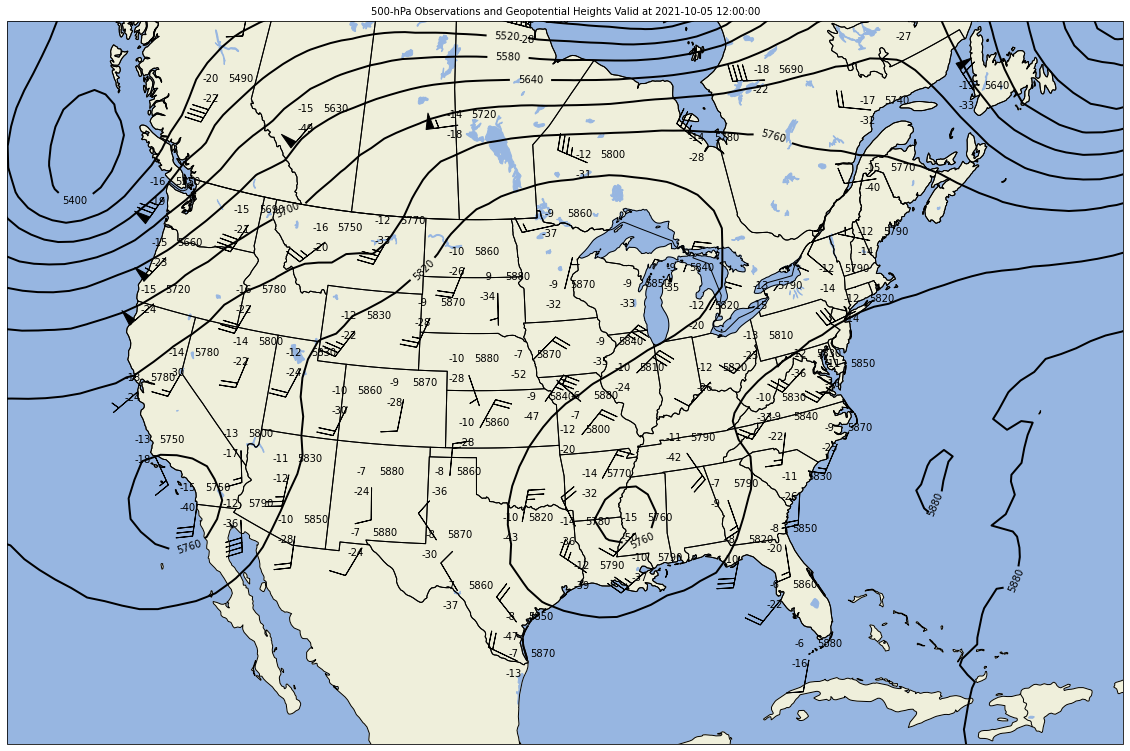

In [5]:
# Add point observations
obs = declarative.PlotObs()
obs.data = data
obs.level = 500 * units.hPa
obs.time = date
obs.fields = ['temperature', 'dewpoint', 'height']
obs.locations = ['NW', 'SW', 'ENE']
obs.vector_field = ['u_wind', 'v_wind']
obs.vector_field_length = 8

# Add contours of geopotential height
cntr = declarative.ContourPlot()
cntr.data = ds
cntr.level = obs.level
cntr.field = 'Geopotential_height_isobaric'
#cntr.field_zoom = (10, 4)
cntr.clabels = True
cntr.contours = list(range(0, 10000, 60))

# Set map panel features
panel = declarative.MapPanel()
panel.projection = 'lcc'
panel.area = [-125, -65, 22, 55]
panel.layers = ['ocean', 'lakes', 'land', 'states', 'borders', 'coastline']
panel.title = f'500-hPa Observations and Geopotential Heights Valid at {date}'
panel.plots = [cntr, obs]

# Add map panel to figure
pc = declarative.PanelContainer()
pc.size = (20, 20)
pc.panels = [panel]

pc.show()